In [ ]:
import matplotlib.animation as animation
import numpy as np
import scipy as sp
import numpy as np                    #using numpy to load and save csv files
import matplotlib.pyplot as plt       #using matplotlib to plot the data

In [ ]:
def solve_induction(d_t=0.01, r_max = 10, t_max = 35, d_r = 0.01, h_val = 0.1,
                    omega_f = lambda r: r*0, alpha_f = lambda r: r*0, V_r_f=lambda r: r*0, V_z_f=lambda r: r*0,
                    eta_m = 0.01, eta_t= 0,
                    B_r_f=lambda r: r*0, B_phi_f=lambda r: r*0):
    """
    Solves the induction equation for a given set of parameters and boundary conditions
    :param d_t: time step
    :param r_max: maximum radius
    :param t_max: maximum time
    :param d_r: radial step
    :param h_val: scale height
    :param omega_f: function for angular velocity
    :param alpha_f: function for alpha
    :param V_r_f: function for radial velocity
    :param V_phi_f: function for azimuthal velocity
    :param V_z_f: function for vertical velocity
    :param eta_m: magnetic diffusivity
    :param eta_t: turbulent magnetic diffusivity
    :param B_r_f: function for radial magnetic field
    :param B_phi_f: function for azimuthal magnetic field
    :return: None
    """
    r_min = 0
    t_min = 0
    r = np.arange(r_min, r_max, d_r) # radial array for uniform radial steps
    dr = np.diff(r, prepend=0)    # radial step array

    h = h_val* np.ones_like(r) # constant scale height h

    t = np.arange(t_min, t_max, d_t) # time array for uniform time steps
    dt = np.diff(t, prepend=0)     # time step array
    d_t = dt[1]
    eta = eta_m + eta_t # total diffusivity

    omega = omega_f(r)
    alpha = alpha_f(r)
    V_r = V_r_f(r)
    V_z = V_z_f(r)

    q_omega = - r * np.gradient(omega, r)  # q = - r d omega / dr
    D = - alpha[0]* q_omega * h[2]**(3) / eta**2    # D = - alpha q / 2 omega
    D = np.average(D)

    B_r = B_r_f(r)
    B_phi = B_phi_f(r)

    B_r_evolution = []
    B_phi_evolution = []
    time = []
    time_evol = []
    B_r_decay = []
    B_phi_decay = []
    B_r_t = B_r
    Bphi_t = B_phi
    r_val = 5
    r_index = np.where(r == r_val)[0][0]
    for i in range(len(dt)):
        time_step = dt[i]
        if i%200 == 0:
            B_r_evolution.append(B_r_t)
            B_phi_evolution.append(Bphi_t)
            time_evol.append(t_min + i*d_t)
        time.append(t_min + i*d_t)
        B_r_decay.append(B_r_t[r_index])
        B_phi_decay.append(Bphi_t[r_index])
        B_r_t,Bphi_t = runge_kutta_step(B_r_t, Bphi_t,r=r, dr=dr, dt=time_step, omega=omega, alpha=alpha, V_r=V_r, V_z=V_z, h=h, eta=eta)


    return B_r_evolution, B_phi_evolution, time_evol , B_r_decay, B_phi_decay, time, r, D

In [ ]:
# Solving Equations iteratively

# The differential equation in Br
def Eqn_Br(Br, Bphi, dr, eta, d_t, r, V_r, V_z, h, alpha):
    k = []
    k.append(0)
    for i in range(1, len(r)-1):
        k_i = d_t*(
                (  V_r[i]/(2*dr[i])         +   eta/(dr[i]**2)   - eta/(2*r[i]*dr[i])    )*Br[i-1] +
                (  -V_r[i]/r[i] + V_z[i]/(4*h[i]) - eta/(r[i]**2) - (2*eta)/(dr[i]**2)
                                            - (eta*np.pi**2)/(4*h[i]**2)                 )*Br[i] +
                (  -V_r[i]/(2*dr[i])        +   eta/(dr[i]**2)   + eta/(2*r[i]*dr[i])    )*Br[i+1] +

                ((2*alpha[i])/(np.pi*h[i]) )*Bphi[i]
            )
        k.append(k_i)
    k.append(0)
    return np.array(k)

# Full Eqn in Bphi
def Eqn_Bphi(Br, Bphi, dr, eta, d_t, r, V_r, V_z, h, alpha, omega):
    k = []
    k.append(0)
    for i in range(1, len(r)-1):
        k_i = d_t*(
                (V_r[i]/(2*dr[i])           + eta/(dr[i]**2) - eta/(2*r[i]*dr[i])       )*Bphi[i-1] +
                ((V_r[i-1] - V_r[i+1])/(2*dr[i]) - V_z[i]/(4*h[i]) - (2*eta)/(dr[i]**2)
                                            - eta/(r[i]**2) - (eta*np.pi**2)/(4*h[i]**2))*Bphi[i] +
                (-V_r[i]/(2*dr[i])          + eta/(dr[i]**2) + eta/(2*r[i]*dr[i])       )*Bphi[i+1] +

                ( -r[i]*(omega[i+1] - omega[i-1])/(2*dr[i])   + (2*alpha[i])/(np.pi*h[i])  )*Br[i] # alpha square term is present here
            )
        k.append(k_i)
    k.append(0)
    return np.array(k)

# Runge Kutta Step
def runge_kutta_step(Br, Bphi, dt, eta, r, dr, V_r, V_z, h, alpha, omega):
    k1_r = dt *  Eqn_Br(Br, Bphi, dr, eta, dt, r, V_r, V_z, h, alpha)
    k1_phi = dt *  Eqn_Bphi(Br, Bphi, dr, eta, dt, r, V_r, V_z, h, alpha, omega)

    k2_r = dt *  Eqn_Br(Br + 0.5 * k1_r, Bphi + 0.5 * k1_phi, dr, eta, dt, r, V_r, V_z, h, alpha)
    k2_phi = dt *  Eqn_Bphi(Br + 0.5 * k1_r, Bphi + 0.5 * k1_phi, dr, eta, dt, r, V_r, V_z, h, alpha, omega)

    k3_r = dt *  Eqn_Br(Br + 0.5 * k2_r, Bphi + 0.5 * k2_phi, dr, eta, dt, r, V_r, V_z, h, alpha)
    k3_phi = dt *  Eqn_Bphi(Br + 0.5 * k2_r, Bphi + 0.5 * k2_phi, dr, eta, dt, r, V_r, V_z, h, alpha, omega)

    k4_r = dt *  Eqn_Br(Br + k3_r, Bphi + k3_phi, dr, eta, dt, r, V_r, V_z, h, alpha)
    k4_phi = dt *  Eqn_Bphi(Br + k3_r, Bphi + k3_phi, dr, eta, dt, r, V_r, V_z, h, alpha, omega)

    return (Br + (k1_r + 2 * k2_r + 2 * k3_r + k4_r) / 6, Bphi + (k1_phi + 2 * k2_phi + 2 * k3_phi + k4_phi) / 6)


### Solving for Different cases of dynamo Number

In [ ]:
def B_r(r):
    return -(r-5)**(2)  + 25

def B_phi(r):
    return (r - 5)**(2) - 25

def alpha(r):
    alpha_0 = 10.0
    return np.ones_like(r)*alpha_0

def omega(r):
    return 10/np.sqrt(1+(r/4)**2)

B_r_ev, B_phi_ev, time_evol, B_r_decay, B_phi_decay, time_decay, r, D = solve_induction(alpha_f=alpha, omega_f=omega, B_r_f=B_r, B_phi_f=B_phi, eta_m=0.01, eta_t=0.2)

Text(0.5, 1.0, 'Initial Conditions')

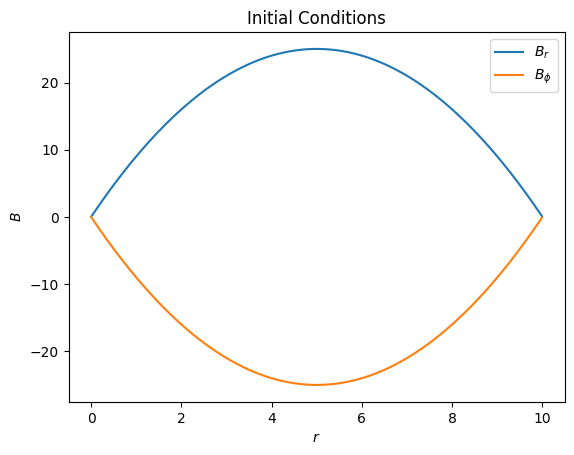

In [ ]:
plt.plot(r, B_r(r), label=r"$B_r$")
plt.plot(r, B_phi(r), label=r"$B_{\phi}$")
plt.xlabel(r"$r$")
plt.ylabel(r"$B$")
plt.legend()
plt.title("Initial Conditions")

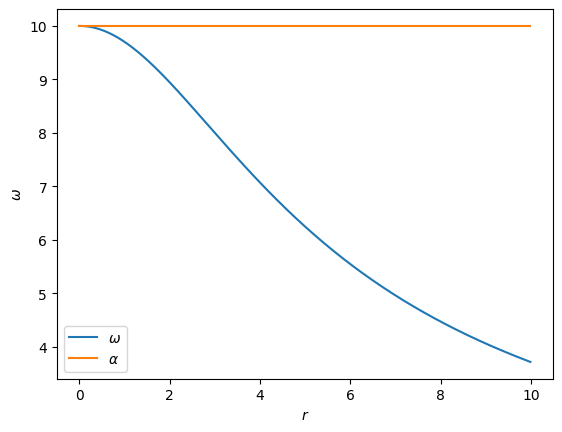

In [ ]:
plt.plot(r, omega(r), label=r"$\omega$")
plt.plot(r, alpha(r), label=r"$\alpha$")
plt.xlabel(r"$r$")
plt.ylabel(r"$\omega$")
plt.legend()


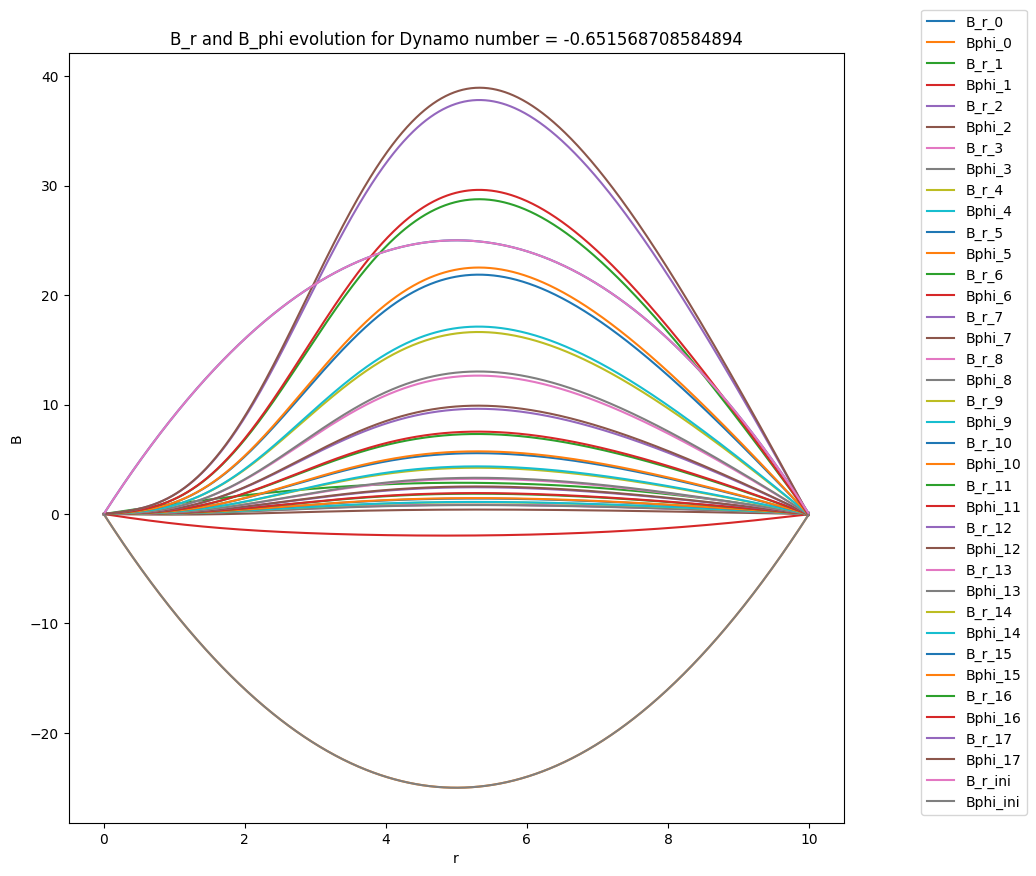

In [ ]:
B_r_evolution = np.array(B_r_ev)
B_phi_evolution = np.array(B_phi_ev)

plt.figure(figsize=(10, 10))
for i in range(len(B_r_evolution)):
    plt.plot(r, B_r_evolution[i], label=f"B_r_{i}")
    plt.plot(r, B_phi_evolution[i], label=f"Bphi_{i}")

#plt.plot(r, B_r_t, label="B_r")
#plt.plot(r, Bphi_t, label="Bphi")
plt.plot(r, B_r(r), label="B_r_ini")
plt.plot(r, B_phi(r), label="Bphi_ini")
plt.legend(loc=(1.1,0.01))
plt.xlabel("r")
plt.ylabel("B")
plt.title(f"B_r and B_phi evolution for Dynamo number = {D}")
plt.show()

In [ ]:
def pitch_angle(B_r, B_phi):
    return np.arctan(B_r/B_phi)

def plot_pitch(B_r_evolution, B_phi_evolution):
    plt.figure(figsize=(10, 10))
    plt.title("Pitch Angle Evolution")
    for i in range(len(B_r_evolution)):
        plt.xlabel("r")
        plt.ylabel("Pitch Angle")
        plt.plot(r, pitch_angle(B_r_evolution[i], B_phi_evolution[i]), label=f"pitch_angle_{i}")
    plt.legend(loc=(1.1,0.01))


/tmp/ipykernel_26971/985979038.py:2: RuntimeWarning: invalid value encountered in divide
  return np.arctan(B_r/B_phi)


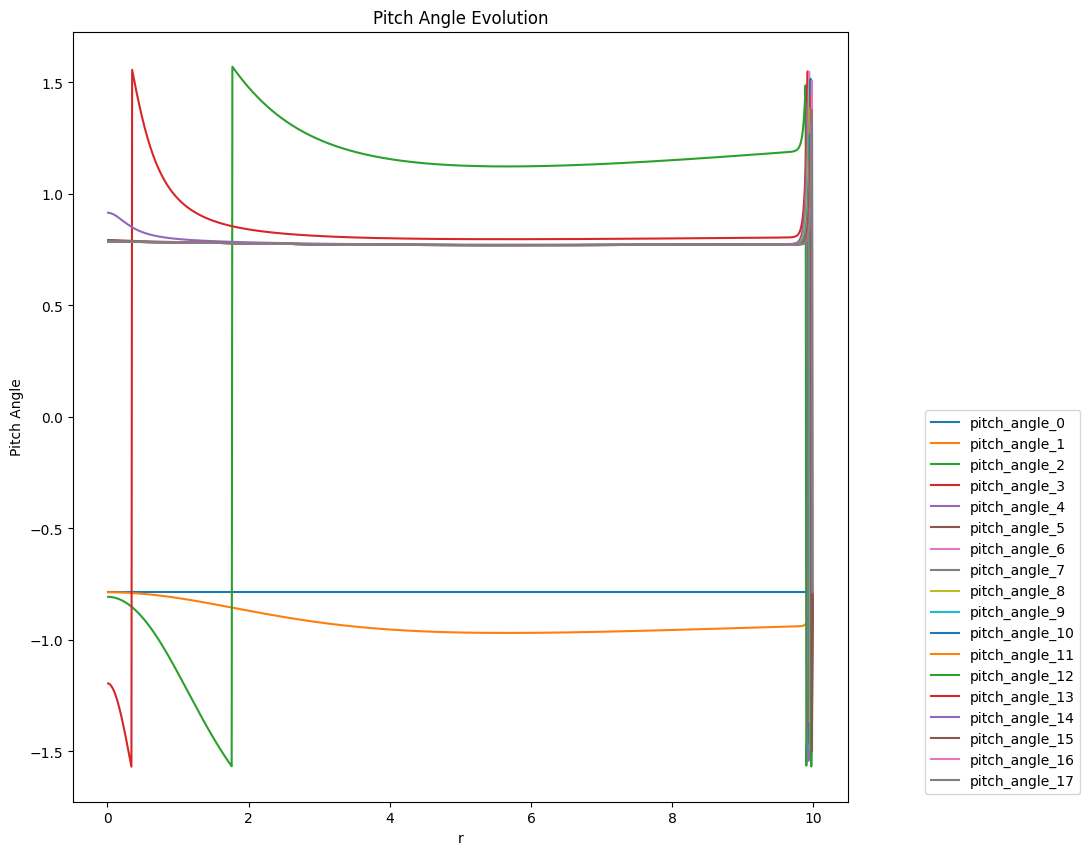

In [ ]:
plot_pitch(B_r_evolution, B_phi_evolution)

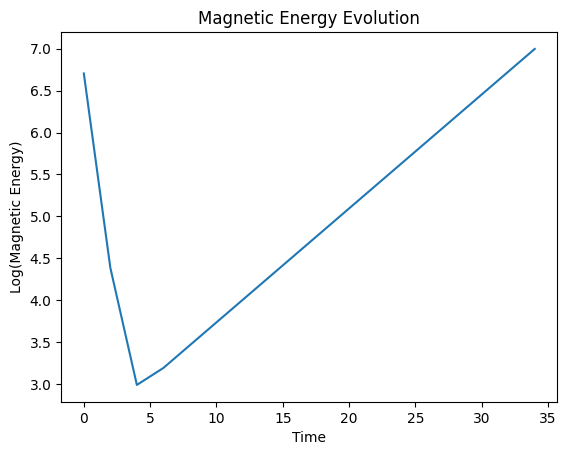

In [ ]:
def magnetic_energy_evol(B_r_evolution, B_phi_evolution, time):
    B_ener = np.zeros_like(B_r_evolution[:,0])
    for i in range(len(B_r_ev)):
        B_tot = np.sqrt(np.sum(B_r_evolution[i]**2 + B_phi_evolution[i]**2))
        B_ener[i] = B_tot

    plt.plot(time, np.log(B_ener))
    plt.xlabel("Time")
    plt.ylabel("Log(Magnetic Energy)")
    plt.title("Magnetic Energy Evolution")
    return B_ener

B1 = magnetic_energy_evol(B_r_evolution, B_phi_evolution, time_evol)
D1 = D
Br1_loc = B_r_decay
Bphi1_loc = B_phi_decay

In [ ]:

def alpha(r):
    alpha_0 = 7.8
    return np.ones_like(r)*alpha_0

def omega(r):
    return 10/np.sqrt(1+(r/4)**2)

B_r_ev, B_phi_ev, time_evol, B_r_decay, B_phi_decay, time_decay, r, D = solve_induction(alpha_f=alpha, omega_f=omega, B_r_f=B_r, B_phi_f=B_phi, eta_m=0.01, eta_t=0.2)

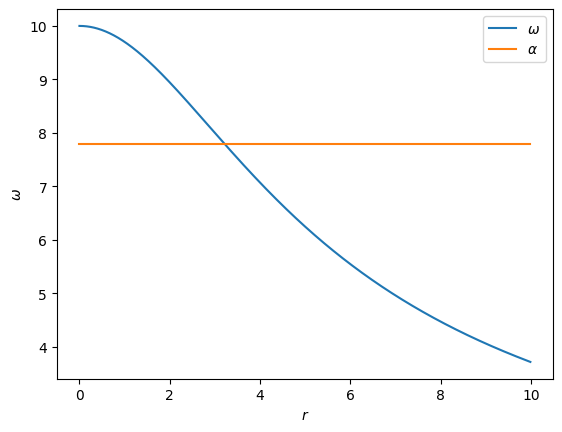

In [ ]:
plt.plot(r, omega(r), label=r"$\omega$")
plt.plot(r, alpha(r), label=r"$\alpha$")
plt.xlabel(r"$r$")
plt.ylabel(r"$\omega$")
plt.legend()


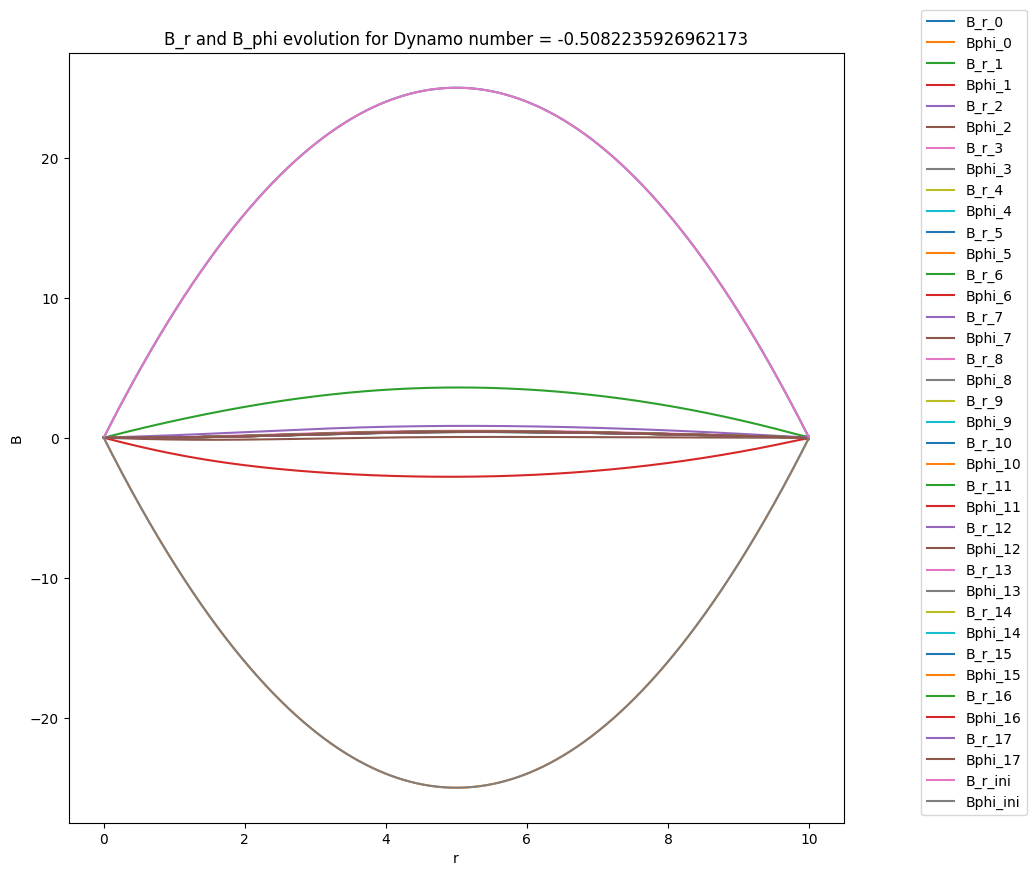

In [ ]:
B_r_evolution = np.array(B_r_ev)
B_phi_evolution = np.array(B_phi_ev)

plt.figure(figsize=(10, 10))
for i in range(len(B_r_evolution)):
    plt.plot(r, B_r_evolution[i], label=f"B_r_{i}")
    plt.plot(r, B_phi_evolution[i], label=f"Bphi_{i}")

#plt.plot(r, B_r_t, label="B_r")plot_pitch(B_r_evolution, B_phi_evolution)
#plt.plot(r, Bphi_t, label="Bphi")
plt.plot(r, B_r(r), label="B_r_ini")
plt.plot(r, B_phi(r), label="Bphi_ini")
plt.legend(loc=(1.1,0.01))
plt.xlabel("r")
plt.ylabel("B")
plt.title(f"B_r and B_phi evolution for Dynamo number = {D}")
plt.show()

/tmp/ipykernel_26971/985979038.py:2: RuntimeWarning: invalid value encountered in divide
  return np.arctan(B_r/B_phi)


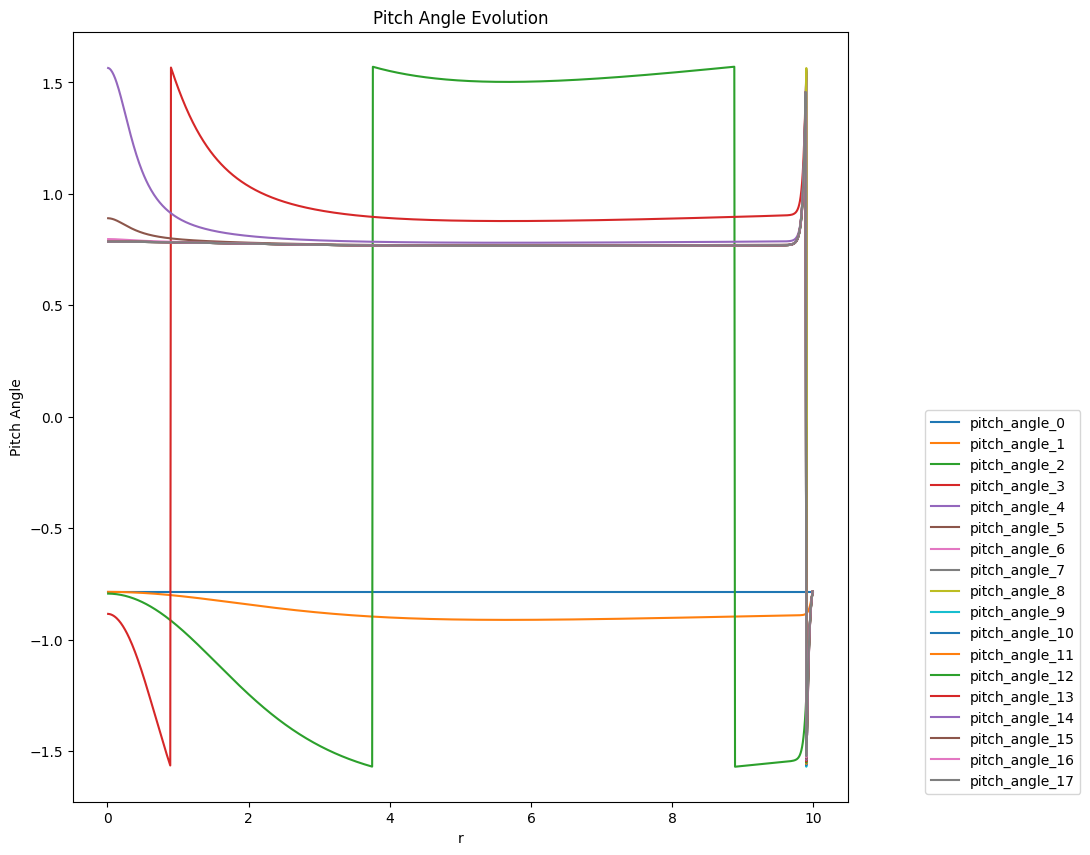

In [ ]:
plot_pitch(B_r_evolution, B_phi_evolution)

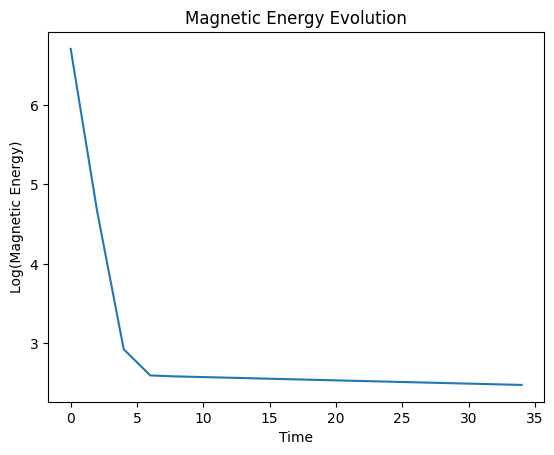

In [ ]:
B2 = magnetic_energy_evol(B_r_evolution, B_phi_evolution, time_evol)
D2 = D
Br2_loc = B_r_decay
Bphi2_loc = B_phi_decay

In [ ]:

def alpha(r):
    alpha_0 = 6.0
    return np.ones_like(r)*alpha_0

def omega(r):
    return 10/np.sqrt(1+(r/4)**2)


B_r_ev, B_phi_ev, time_evol, B_r_decay, B_phi_decay, time_decay, r, D = solve_induction(alpha_f=alpha, omega_f=omega, B_r_f=B_r, B_phi_f=B_phi, eta_m=0.01, eta_t=0.2)

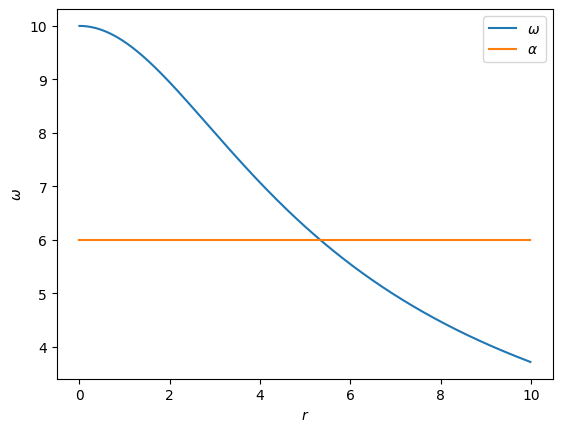

In [ ]:
plt.plot(r, omega(r), label=r"$\omega$")
plt.plot(r, alpha(r), label=r"$\alpha$")
plt.xlabel(r"$r$")
plt.ylabel(r"$\omega$")
plt.legend()

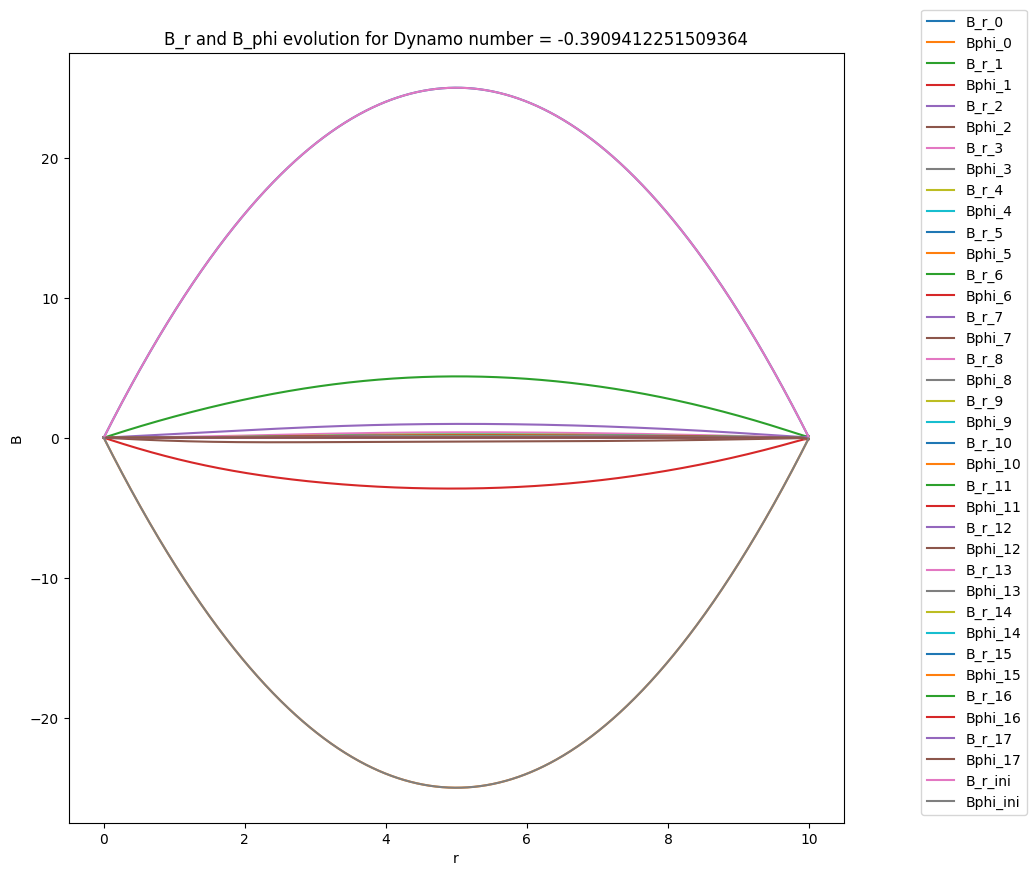

In [ ]:
B_r_evolution = np.array(B_r_ev)
B_phi_evolution = np.array(B_phi_ev)

plt.figure(figsize=(10, 10))
for i in range(len(B_r_evolution)):
    plt.plot(r, B_r_evolution[i], label=f"B_r_{i}")
    plt.plot(r, B_phi_evolution[i], label=f"Bphi_{i}")

#plt.plot(r, B_r_t, label="B_r")
#plt.plot(r, Bphi_t, label="Bphi")
plt.plot(r, B_r(r), label="B_r_ini")
plt.plot(r, B_phi(r), label="Bphi_ini")
plt.legend(loc=(1.1,0.01))
plt.xlabel("r")
plt.ylabel("B")
plt.title(f"B_r and B_phi evolution for Dynamo number = {D}")
plt.show()

/tmp/ipykernel_26971/985979038.py:2: RuntimeWarning: invalid value encountered in divide
  return np.arctan(B_r/B_phi)


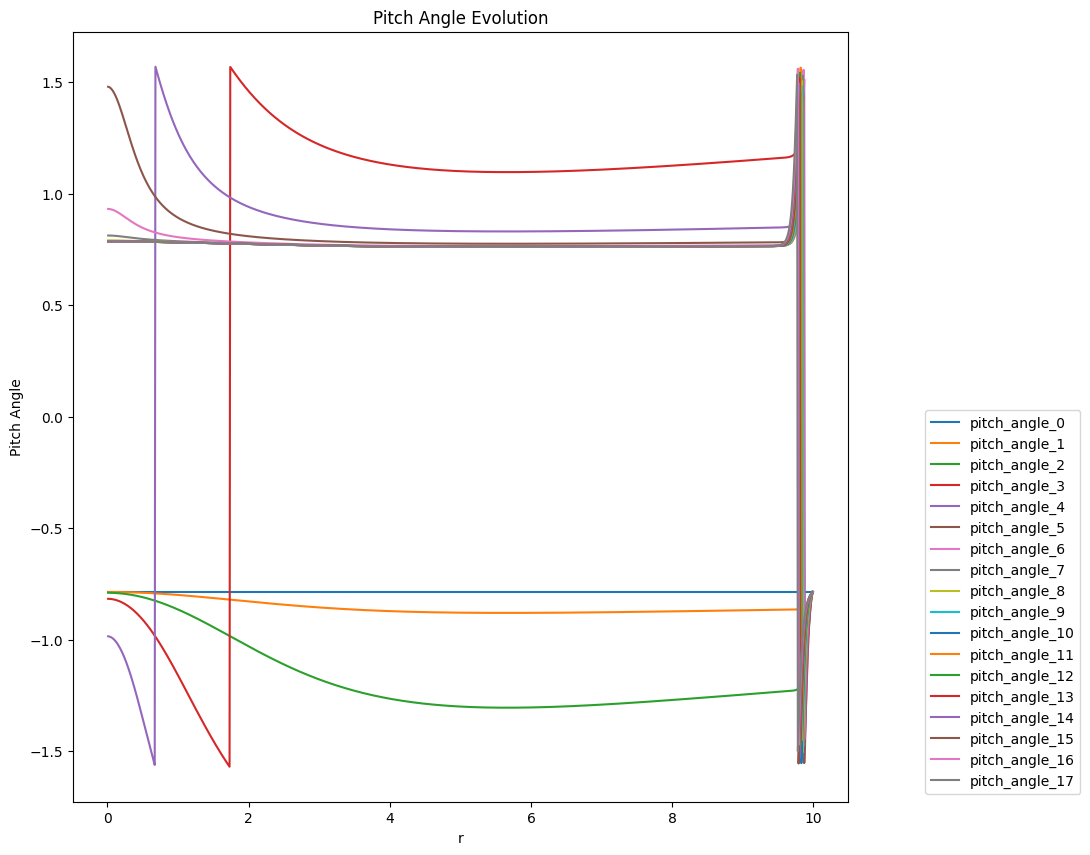

In [ ]:
plot_pitch(B_r_evolution, B_phi_evolution)

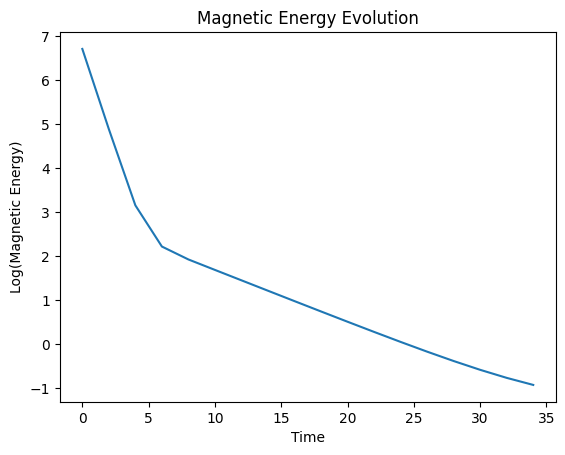

In [ ]:
B3 = magnetic_energy_evol(B_r_evolution, B_phi_evolution, time_evol)
D3 = D
Br3_loc = B_r_decay
Bphi3_loc = B_phi_decay

#### Comparison of different dynamo numbers

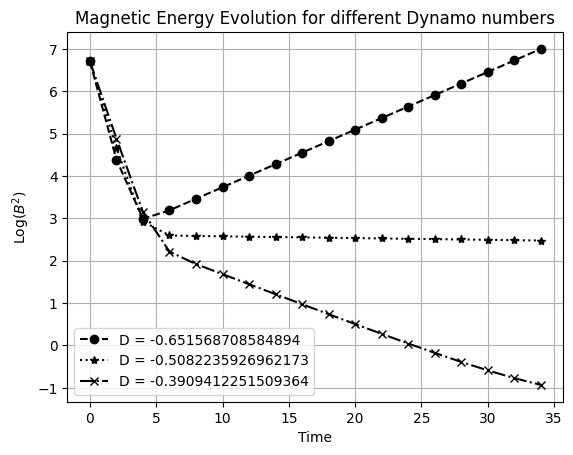

In [ ]:
plt.plot(time_evol, np.log(B1), ls="--", color='k',marker = 'o', label=f"D = {D1}")
plt.plot(time_evol, np.log(B2), ls=":", color='k',marker = '*',label=f"D = {D2}")
plt.plot(time_evol, np.log(B3), ls='-.',color='k', marker = 'x', label=f"D = {D3}")
plt.xlabel("Time")
plt.ylabel(r"Log($B^2$)")
plt.legend()
plt.title("Magnetic Energy Evolution for different Dynamo numbers")
plt.grid()

Text(0.5, 1.0, 'Magnetic Field Decay for different Dynamo numbers at r = 5')

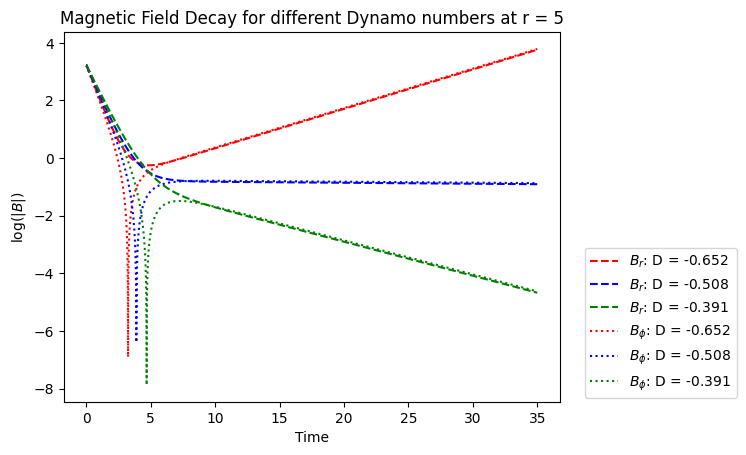

In [ ]:
plt.plot(time_decay, np.log(Br1_loc), ls="--",marker = ' ',color='r', label=  r"$B_r$: "+ f"D = {D1.round(3)}" )
plt.plot(time_decay, np.log(Br2_loc), ls="--",marker = ' ',color='b',label= r"$B_r$: "+f"D = {D2.round(3)}")
plt.plot(time_decay, np.log(Br3_loc), ls='--', marker = ' ',color='g', label=r"$B_r$: "+f"D = {D3.round(3)}")
plt.plot(time_decay, np.log(np.abs(Bphi1_loc)), ls=":", color='r',marker = ' ', label=r"$B_{\phi}$: "+f"D = {D1.round(3)}")
plt.plot(time_decay, np.log(np.abs(Bphi2_loc)), ls=":", color='b',marker = ' ',label=r"$B_{\phi}$: "+f"D = {D2.round(3)}")
plt.plot(time_decay, np.log(np.abs(Bphi3_loc)), ls=':',color='g', marker = ' ', label=r"$B_{\phi}$: "+f"D = {D3.round(3)}")
plt.xlabel("Time")
plt.legend(loc=(1.05,0.01))
plt.ylabel(r"log(|$B$|)")
plt.title("Magnetic Field Decay for different Dynamo numbers at r = 5")

### Solving the same Equation for different initial conditions
We have used a Dynamo number which is greater than 0.5 in the following cases. $\alpha$ and $\Omega$ terms remain same.

In [ ]:
def alpha(r):
    alpha_0 = 10.0
    return np.ones_like(r)*alpha_0

def omega(r):
    return 10/np.sqrt(1+(r/4)**2)


Text(0, 0.5, '$B$')

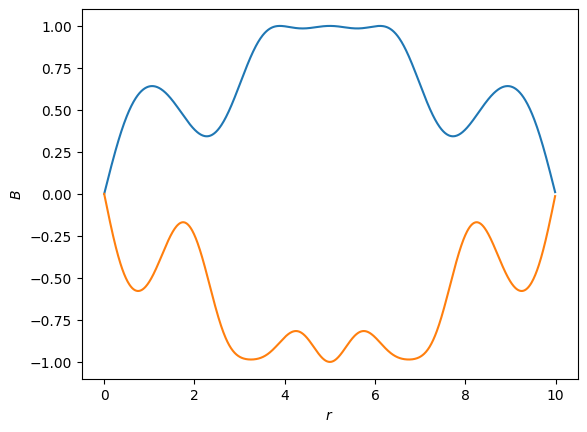

In [ ]:

def B_r(r):
    return np.sin( 0.4*np.sin(np.pi *6* (r) / (10)) + np.pi * (r) / (10)) # np.ones(len(r)) * np.sin(np.pi * r)
def B_phi(r):
    return - np.sin( 0.4*np.sin(np.pi *8* (r) / (10)) + np.pi * (r) / (10))  # np.ones(len(r)) * np.sin(np.pi * r)

plt.plot(r, B_r(r), label=r"$B_r$")
plt.plot(r, B_phi(r), label=r"$B_{\phi}$")
plt.xlabel(r"$r$")
plt.ylabel(r"$B$")

In [ ]:
B_r_ev, B_phi_ev, time_evol, B_r_decay, B_phi_decay, time_decay, r, D = solve_induction(t_max=15, alpha_f=alpha, omega_f=omega, B_r_f=B_r, B_phi_f=B_phi, eta_m=0.01, eta_t=0.2)

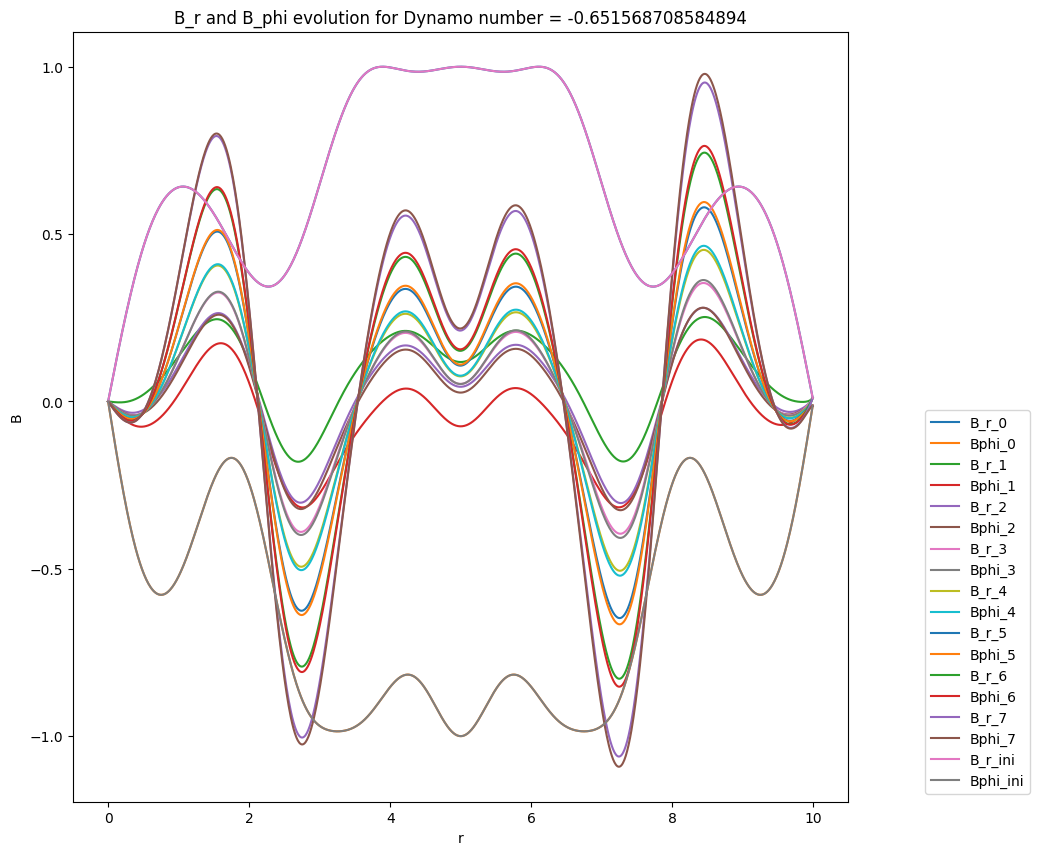

In [ ]:
B_r_evolution = np.array(B_r_ev)
B_phi_evolution = np.array(B_phi_ev)

plt.figure(figsize=(10, 10))
for i in range(len(B_r_evolution)):
    plt.plot(r, B_r_evolution[i], label=f"B_r_{i}")
    plt.plot(r, B_phi_evolution[i], label=f"Bphi_{i}")

#plt.plot(r, B_r_t, label="B_r")plot_pitch(B_r_evolution, B_phi_evolution)
#plt.plot(r, Bphi_t, label="Bphi")
plt.plot(r, B_r(r), label="B_r_ini")
plt.plot(r, B_phi(r), label="Bphi_ini")
plt.legend(loc=(1.1,0.01))
plt.xlabel("r")
plt.ylabel("B")
plt.title(f"B_r and B_phi evolution for Dynamo number = {D}")
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

def update(frame):
    ax.clear()
    ax.set_xlabel('r')
    ax.set_ylabel('B')
    ax.plot(r, B_r_evolution[frame], label=f"B_r_{frame}")
    ax.plot(r, B_phi_evolution[frame], label=f"Bphi_{frame}")
    ax.set_xlim(0, 10)
    ax.set_ylim(-1, 1)
    ax.legend(loc=(0.9, 0.01))
    ax.set_title(f"Frame {frame}")

ani = animation.FuncAnimation(fig, update, frames=len(B_r_evolution), interval=200)
plt.close()

ani.save('B_dynamo_evol_1.gif', writer='imagemagick', fps=3)

Text(0, 0.5, '$B$')

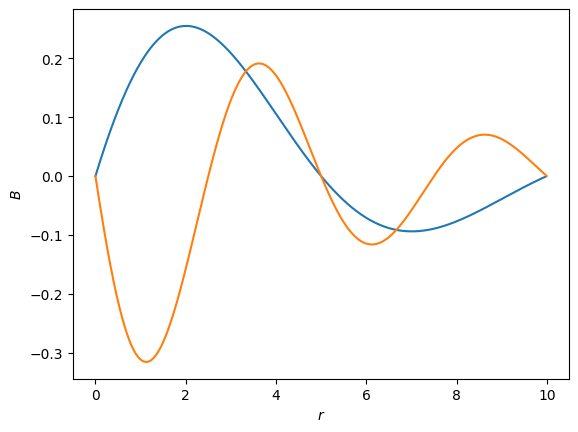

In [ ]:
def B_r(r):
    return np.exp(-2*r/(10))* 0.4*np.sin(np.pi *2* (r) / (10))
def B_phi(r):
     return -np.exp(-2*r/10)* 0.4*np.sin(np.pi *4* (r) / (10))  # np.ones(len(r)) * np.sin(np.pi * r)

plt.plot(r, B_r(r), label=r"$B_r$")
plt.plot(r, B_phi(r), label=r"$B_{\phi}$")
plt.xlabel(r"$r$")
plt.ylabel(r"$B$")

In [ ]:
B_r_ev, B_phi_ev, time_evol, B_r_decay, B_phi_decay, time_decay, r, D = solve_induction(t_max=15, alpha_f=alpha, omega_f=omega, B_r_f=B_r, B_phi_f=B_phi, eta_m=0.01, eta_t=0.2)

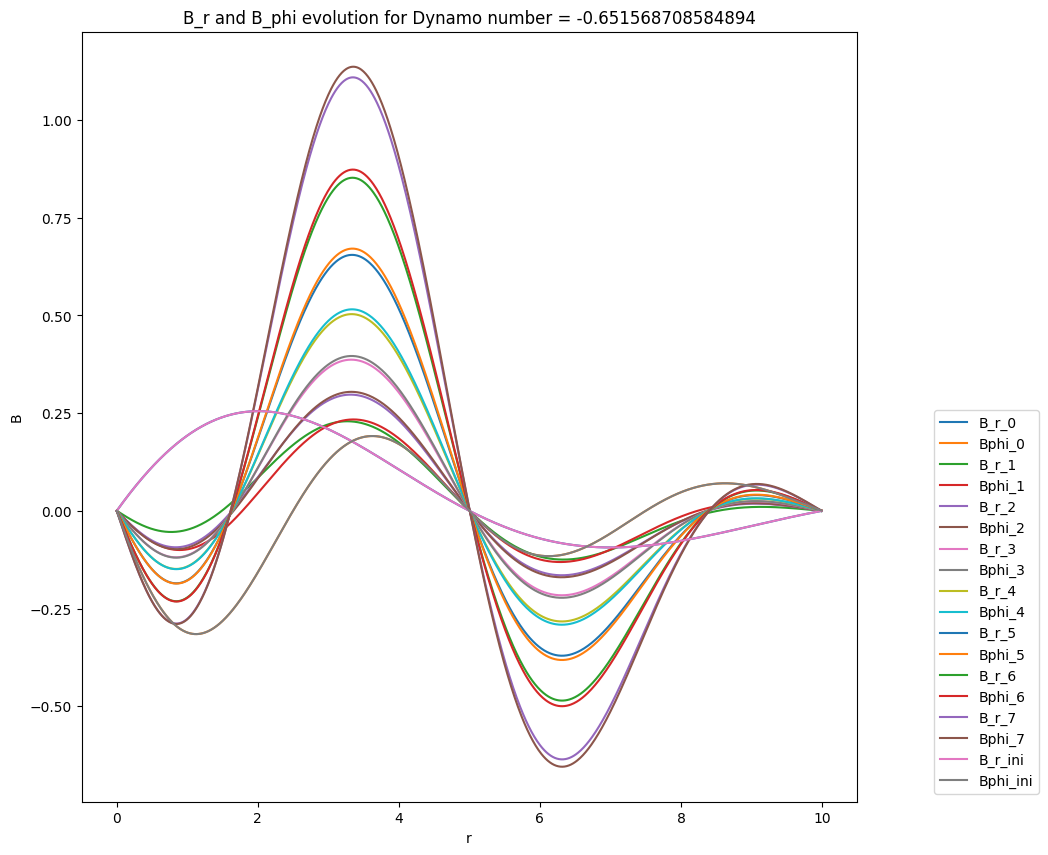

In [ ]:
B_r_evolution = np.array(B_r_ev)
B_phi_evolution = np.array(B_phi_ev)

plt.figure(figsize=(10, 10))
for i in range(len(B_r_evolution)):
    plt.plot(r, B_r_evolution[i], label=f"B_r_{i}")
    plt.plot(r, B_phi_evolution[i], label=f"Bphi_{i}")

#plt.plot(r, B_r_t, label="B_r")plot_pitch(B_r_evolution, B_phi_evolution)
#plt.plot(r, Bphi_t, label="Bphi")
plt.plot(r, B_r(r), label="B_r_ini")
plt.plot(r, B_phi(r), label="Bphi_ini")
plt.legend(loc=(1.1,0.01))
plt.xlabel("r")
plt.ylabel("B")
plt.title(f"B_r and B_phi evolution for Dynamo number = {D}")
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

def update(frame):
    ax.clear()
    ax.set_xlabel('r')
    ax.set_ylabel('B')
    ax.plot(r, B_r_evolution[frame], label=f"B_r_{frame}")
    ax.plot(r, B_phi_evolution[frame], label=f"Bphi_{frame}")
    ax.set_xlim(0, 10)
    ax.set_ylim(-1, 1)
    ax.legend(loc=(0.9, 0.01))
    ax.set_title(f"Frame {frame}")

ani = animation.FuncAnimation(fig, update, frames=len(B_r_evolution), interval=200)
plt.close()

ani.save('B_dynamo_evol_2.gif', writer='imagemagick', fps=3)